# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn
from sklearn.metrics import accuracy_score, auc, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Load Dataset and Configure

In [2]:
path = './data/Debernardi et al 2020 data.csv'

df_orig = pd.read_csv(path)

# Map index for diagnosis value to label
diag_map = {1: 'control', 2: 'benign', 3: 'cancer'}

# Show the head of the unmodified dataset
display(df_orig)

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


# Clean Dataset

In [3]:
df_clean = df_orig.copy()

# Replace NaNs in 'stage' with 0 (no cancer)
df_clean[['stage']] = df_clean[['stage']].fillna(value='0')

# Transform 'stage' into into numerical labels
stage_encoder = LabelEncoder()
stage_encoder.fit(df_clean['stage'].unique())
df_clean['stage'] = stage_encoder.transform(df_clean['stage'])

# Drop the 'benign_sample_diagnosis' (let's just figure out if it is cancer or not)
df_clean = df_clean.drop(labels='benign_sample_diagnosis', axis=1)

# Drop 'patient_cohort'
df_clean = df_clean.drop(labels='patient_cohort', axis=1)

# Drop 'sample_origin'
df_clean = df_clean.drop(labels='sample_origin', axis=1)

# Tranform 'sex' into numerical labels
sex_encoder = LabelEncoder()
sex_encoder.fit(df_clean['sex'].unique())
df_clean['sex'] = sex_encoder.transform(df_clean['sex'])

df_clean.head()

,sample_id,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,33,0,1,0,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,81,0,1,0,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,51,1,1,0,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,61,1,1,0,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,62,1,1,0,9.0,0.21489,0.000860,65.54000,41.088000,NaN


# Explore

## Check Datatypes

In [4]:
display(df_clean.dtypes)

sample_id         object
age                int64
sex                int64
diagnosis          int64
stage              int64
plasma_CA19_9    float64
creatinine       float64
LYVE1            float64
REG1B            float64
TFF1             float64
REG1A            float64
dtype: object

## Initial Statistics

The minima for 'plasma_CA19_9' and 'REG1A' seem a little weird to me, but it's only 8 rows so I'm going to ignore it as a weird fluke.

In [5]:
display(df_clean.describe())

,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,0.493220,2.027119,2.091525,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.500378,0.804873,3.039932,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,0.000000,1.000000,0.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,0.000000,1.000000,0.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,0.000000,2.000000,0.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,1.000000,3.000000,6.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,1.000000,3.000000,8.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


#### What's up with those zeros?

In [6]:
df_temp1 = df_clean.loc[df_clean['plasma_CA19_9'] == 0]
df_temp2 = df_clean.loc[df_clean['REG1A'] == 0]
df_temp = pd.concat([df_temp1, df_temp2])

display(df_temp)
print(f'Rows of 0.0 values: {df_temp.shape[0]}')

,sample_id,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
77,S169,50,0,1,0,0.00,0.53157,0.005046,5.381445,5.046098,NaN
102,S26,51,1,1,0,6.94,0.19227,0.571181,3.099211,39.729131,0.0
108,S31,49,1,1,0,7.86,0.32799,0.011929,6.008635,5.637440,0.0
111,S34,46,1,1,0,6.58,0.35061,0.001402,2.191019,33.193840,0.0
156,S75,28,0,1,0,84.30,0.32799,0.001312,7.520023,19.210785,0.0
301,S252,48,1,2,0,46.10,0.76908,0.260904,4.644778,69.315200,0.0
306,S281,62,1,2,0,30.00,0.09048,0.000362,3.130000,6.261730,0.0
553,S533,68,1,3,7,422.00,0.28275,1.706775,2.632109,25.096922,0.0


Rows of 0.0 values: 8


#### Check our diagnosis counts

In [7]:
df_temp = df_clean['diagnosis'].map(diag_map)

display(df_temp.value_counts())

benign     208
cancer     199
control    183
Name: diagnosis, dtype: int64

## Check for NaNs

These missing values are due to differences in data collection methodology ('plasma_CA19_9' and 'REG1A'). We will impute to mean by group (control, benign, cancer).

In [8]:
print(df_clean.isna().sum())

sample_id          0
age                0
sex                0
diagnosis          0
stage              0
plasma_CA19_9    240
creatinine         0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
dtype: int64


## Find outliers

#### First let's make some functions

In [9]:
# Show scatterplots
def show_plots(column: str, df=df_clean, ylabel: str = None):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(df['sample_id'], df[column], c=df['diagnosis'])
    
    plt.title(column)
    plt.xlabel('Sample ID')
    if ylabel:
        plt.ylabel(ylabel)
    
    plt.show()
    
# Show the top 5 values per data column
def show_top_five(column:str, df=df_clean):
    df = df[['sample_id', 'age', 'sex', 'diagnosis', 'stage', column]]
    df = df.sort_values(by=column, ascending=False)
    display(df.head())
    
# Hi-pass Filter
def hipass(column: str, max_val: float, df=df_clean):
    df = df[df[column] <= max_val]

### Check for monoclonal antibody outliers

I think we can ignore the obvious issues (looks like things were misrecorded by an order of magnitude in some of those) in the cancer group as it appears that elevated plasma_CA19_9 is positivley correlated with cancer (with a couple of ignorable outliers in the benign category).

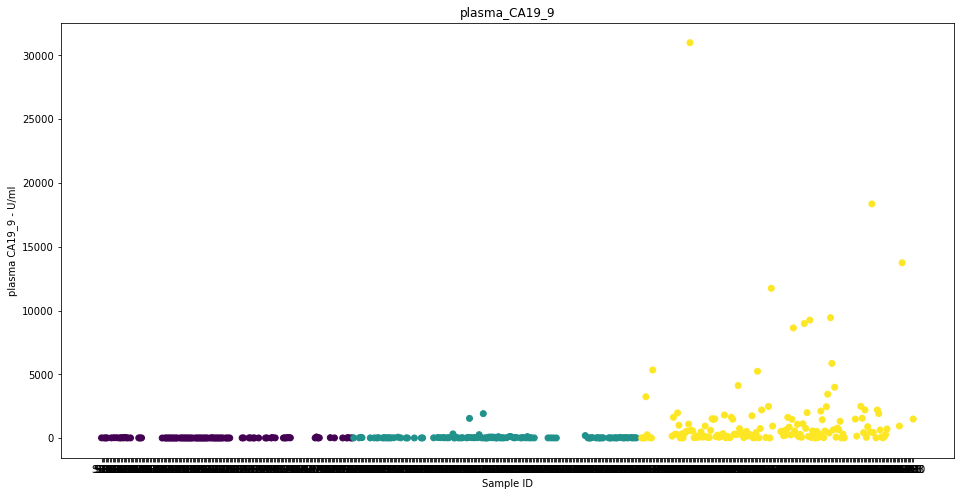

,sample_id,age,sex,diagnosis,stage,plasma_CA19_9
427,S399,69,1,3,6,31000.0
559,S563,53,1,3,7,18360.0
581,S529,61,0,3,8,13740.0
486,S567,66,1,3,6,11740.0
529,S479,60,1,3,7,9436.0


In [10]:
# Show scatterplot
show_plots('plasma_CA19_9', ylabel='plasma CA19_9 - U/ml')

# Show top 5
show_top_five('plasma_CA19_9')

### Check for outliers in creatinine

Nothing actionable here.

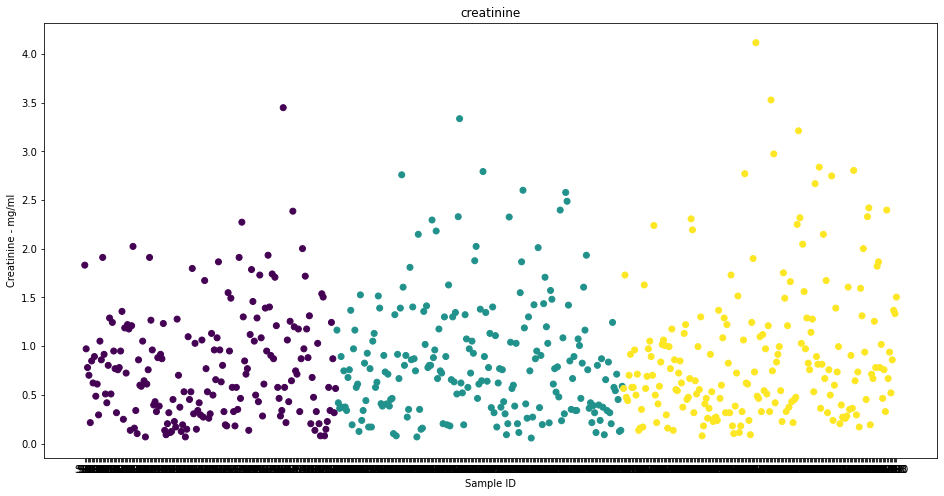

,sample_id,age,sex,diagnosis,stage,creatinine
487,S572,66,0,3,6,4.11684
498,S400,76,1,3,7,3.52872
144,S64,48,0,1,0,3.44955
272,S205,31,1,2,0,3.33645
518,S460,56,1,3,7,3.21204


In [11]:
# Show scatterplot
show_plots('creatinine', ylabel='Creatinine - mg/ml')

# Show top 5
show_top_five('creatinine')

### Check for outliers in LYVE1

From here I think one of the cancer group is clearly entered wrong, I think it is the same egregious one as in the 'plasma_CA19_9' plot. Think I will set a 'high-pass filter' for both of these values.

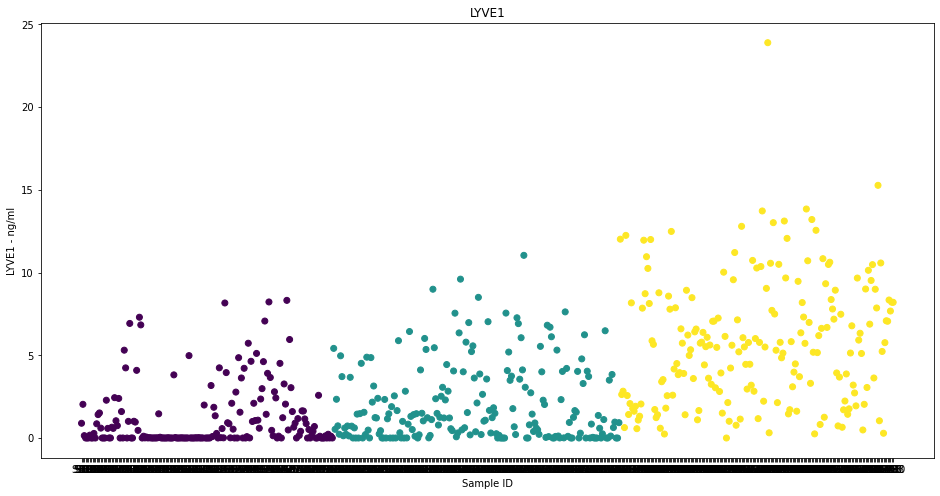

,sample_id,age,sex,diagnosis,stage,LYVE1
498,S400,76,1,3,7,23.890323
578,S514,78,1,3,8,15.270520
526,S474,75,0,3,7,13.840416
494,S393,66,0,3,7,13.721790
530,S480,66,1,3,7,13.204670


In [12]:
# Show scatterplot
show_plots('LYVE1', ylabel='LYVE1 - ng/ml')

# Show top 5
show_top_five('LYVE1')

### Check for outliers in REG1B

We will leave this one alone.

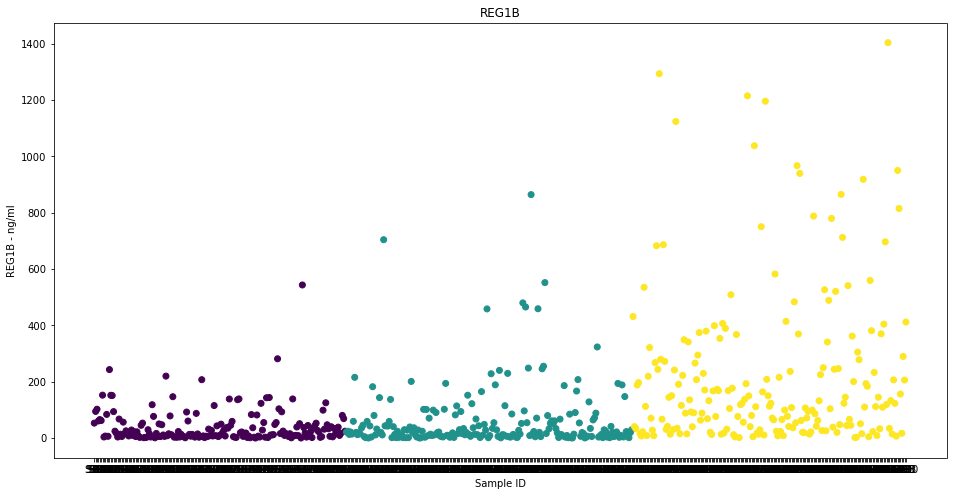

,sample_id,age,sex,diagnosis,stage,REG1B
576,S509,65,1,3,8,1403.89760
410,S504,54,1,3,4,1293.81945
474,S544,79,0,3,6,1215.16800
487,S572,66,0,3,6,1195.97200
422,S527,48,1,3,5,1124.10800


In [13]:
# Show scatterplot
show_plots('REG1B', ylabel='REG1B - ng/ml')

# Show top 5
show_top_five('REG1B')

### Check for outliers in TFF1

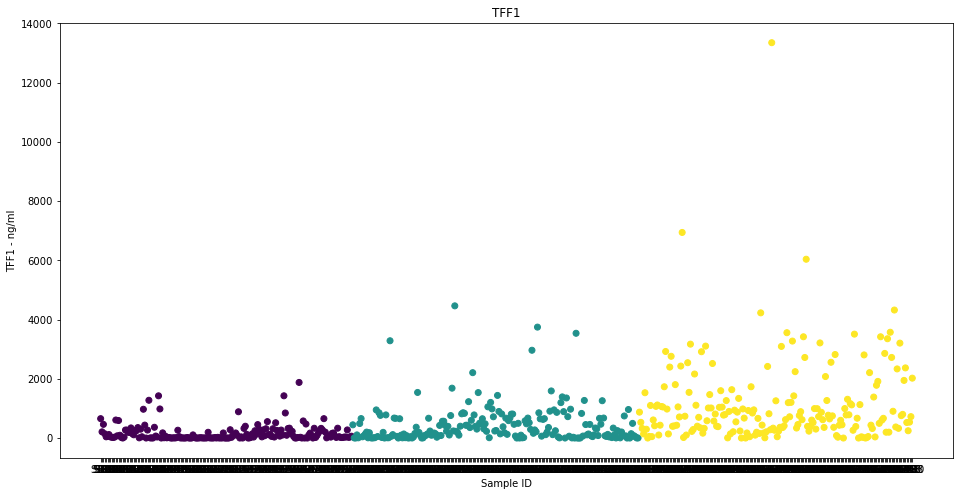

,sample_id,age,sex,diagnosis,stage,TFF1
487,S572,66,0,3,6,13344.300
422,S527,48,1,3,5,6939.098
512,S439,67,0,3,7,6035.157
257,S190,67,1,2,0,4461.684
576,S509,65,1,3,8,4320.489


In [14]:
# Show scatterplot
show_plots('TFF1', ylabel='TFF1 - ng/ml')

# Show top 5
show_top_five('TFF1')

### Check for REG1A antibody outliers

Imputation really does a number here.

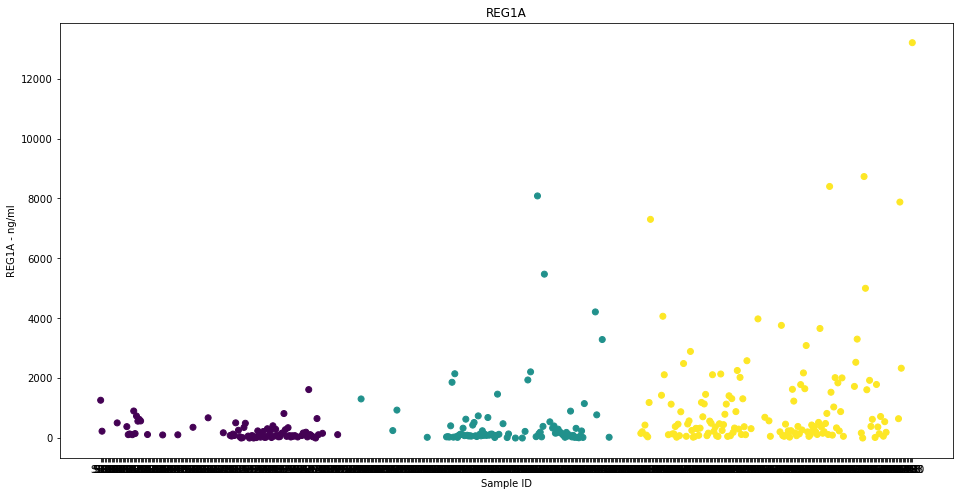

,sample_id,age,sex,diagnosis,stage,REG1A
589,S590,74,1,3,8,13200.000
554,S536,60,1,3,7,8731.000
529,S479,60,1,3,7,8400.000
317,S224,54,0,2,0,8083.492
580,S522,46,1,3,8,7879.000


In [15]:
# Show scatterplot
show_plots('REG1A', ylabel='REG1A - ng/ml')

# Show top 5
show_top_five('REG1A')

## Impute NaNs

In [16]:
df_imp = df_clean.copy()
df_imp['plasma_CA19_9'] = df_imp[['diagnosis','plasma_CA19_9']].groupby('diagnosis').transform(lambda x: x.fillna(x.mean()))
df_imp['REG1A'] = df_imp[['diagnosis', 'REG1A']].groupby('diagnosis').transform(lambda x: x.fillna(x.mean()))

# Reassign df_clean
df_clean = df_imp

# Check
display(df_clean.isna().sum())

sample_id        0
age              0
sex              0
diagnosis        0
stage            0
plasma_CA19_9    0
creatinine       0
LYVE1            0
REG1B            0
TFF1             0
REG1A            0
dtype: int64

## Filter outliers

In [17]:
df = df_clean.copy()

df = df[df['plasma_CA19_9'] < 20000]
df = df[df['LYVE1'] < 20]
df = df[df['TFF1'] < 10000]
df = df[df['REG1A'] < 10000]

display(df)

,sample_id,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,33,0,1,0,11.700000,1.83222,0.893219,52.94884,654.282174,1262.000000
1,S10,81,0,1,0,8.749569,0.97266,2.037585,94.46703,209.488250,228.407000
2,S100,51,1,1,0,7.000000,0.78039,0.145589,102.36600,461.141000,227.871886
3,S101,61,1,1,0,8.000000,0.70122,0.002805,60.57900,142.950000,227.871886
4,S102,62,1,1,0,9.000000,0.21489,0.000860,65.54000,41.088000,227.871886
...,...,...,...,...,...,...,...,...,...,...,...
584,S548,66,1,3,8,1476.154733,0.93873,7.085637,815.13600,2367.590000,1138.323721
585,S549,68,1,3,8,1476.154733,0.52026,7.058209,156.24100,525.178000,1138.323721
586,S558,71,0,3,8,1476.154733,0.85956,8.341207,16.91500,245.947000,1138.323721
587,S560,63,1,3,8,1476.154733,1.36851,7.674707,289.70100,537.286000,1138.323721


## Statistics after Imputation and Culling

We only changed 'plasma_CA19_9' and 'REG1A.' The mean and std moved down for both as expected. 

In [18]:
display(df.describe())

,age,sex,diagnosis,stage,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,58.996587,0.491468,2.020478,2.059727,466.147435,0.845376,2.998074,109.374198,567.029955,626.416130
std,13.111357,0.500354,0.803576,3.024942,1446.575879,0.615665,3.313097,191.260757,854.062388,963.718728
min,26.000000,0.000000,1.000000,0.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,0.000000,1.000000,0.000000,8.749569,0.373230,0.159406,10.524493,43.391500,195.201000
50%,60.000000,0.000000,2.000000,0.000000,41.500000,0.723840,1.626669,34.121743,253.909200,369.076000
75%,69.000000,1.000000,3.000000,6.000000,188.525000,1.131000,5.154961,119.058537,722.041528,547.458092
max,89.000000,1.000000,3.000000,8.000000,18360.000000,3.449550,15.270520,1403.897600,6939.098000,8731.000000


# Let's see what scikit can do from here

## Initialize Models

In [22]:
# Decision Tree
dtc = DecisionTreeClassifier()

# SVM
svc = SVC()

# MLP
mlp = MLPClassifier()

models = [dtc, svc, mlp]

## Split Data

In [ ]:
X = df.loc[:, df.columns != 'diagnosis' & df.columns != 'stage']
Y_cancer = df.loc[:, df.columns ]
Y_stage = 


def run_models(models, x=X, y=Y, test_size=0.5):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size)

    scores = {}
    
    # Run train and test
    for model in models:
        print(f"Running {model}") # SVC w/ probability is slow
        model = model.fit(x_train, y_train)
        
        #y_probs = model.predict_proba(x_test)[:, 1]
        y_pred = model.predict(x_test)
        
        #precision, recall, _ = precision_recall_curve(y_test, y_probs, pos_label=1)
        #auprc = auc(recall, precision)
        
        f1 = f1_score(y_test, y_pred) # per office hours
        
        accuracy = accuracy_score(y_test, y_pred)
        
        scores[model] = accuracy, f1
        
    return scores